In [543]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [544]:
#import libraries
%matplotlib inline     
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



from IPython.display import Image, HTML
from plotnine import *
import pydot
from plotnine import *
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

In [545]:
import xgboost as xgb

In [546]:
# Import dataset from csv to data frame
train=pd.read_csv('data/train.csv')
test=pd.read_csv('date/test.csv')

#train.head(30)

In [547]:
#check for missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [548]:
#check for missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [549]:
#look at the mean, std, min, max etc of the speed
train['speed'].describe()

count    14006.000000
mean        32.779118
std         13.573813
min          2.573417
25%         19.301089
50%         36.580595
75%         45.877665
max         53.161286
Name: speed, dtype: float64

In [550]:
#split 'date' column into 'day', 'month', 'year', 'time', 'hour' separately
from datetime import datetime, date
from time import strptime

train.date = pd.to_datetime(train.date)
train['day'] = train.date.dt.day
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['time'] = train.date.dt.time
train['hour'] = train['time'].apply(lambda x: x.strftime('%H:%M:%S').split(':')[0])
train['hour'] = train['hour'].astype(int) 
train['weekdays'] = train.date.dt.dayofweek+1  #check for the day of the week 
train['isweekend'] = train['weekdays'].apply(lambda x: 1 if x > 5 else 0) #check for the weekend
train['dateonly'] = train['date'].dt.strftime('%Y-%m-%d')
train['dayofyear'] = train.date.dt.dayofyear


#divide months in four quarters 
def quarters(z):
    first = [1,2,3]
    second = [4,5,6]
    third = [7,8,9]
    forth = [10,11,12]
    if z in first:
        return '1'
    elif z in second:
        return '2'
    elif z in third:
        return '3'
    else:
        return '4' 
train['quarter'] = train['month'].apply(quarters).astype(int)

'''
#check for raining months
def raining(r):
    r17 = [5,6,7,8,9]
    y18 = [1,6,8,9,11]
    if train['year'] == '2017':
        if r in y17:
            return '1'
        else:
            return '0'
    else:
        if r in y18:
            return '1'
        else:
            return '0'
train['rainmonth'] = train['month'].apply(raining).astype(int)
'''

#check for time period
def timeperiod(y):
  morningPeak = [7, 8, 9,10,11, 12,13,14,15] #morinig peek in hk
  eveningPeak = [16, 17,18,19] #evening peek in hk
  #noon = [9,10,18]
  #afternoon = [12,13, 14, 15]
  weehour = [0,1,2,3, 4, 5, 6] #ealry morning 
  evening = [20, 21, 22,23]
  if y in morningPeak:
    return '2'
  elif y in eveningPeak:
    return '5'
  elif y in weehour:
    return '1'
  else:
    return '6'

'''
def timeperiod(y):
    Peak = [7,8,9,10,11,12,13,14,15,16,17,18,19]
    if y in Peak:
        return '1'
    else:
        return '0'
    
'''
train['timePeriod'] = train['hour'].apply(timeperiod).astype(int) 


print(train)
#train.head(20)


          id                date      speed  day  month  year      time  hour  \
0          0 2017-01-01 00:00:00  43.002930    1      1  2017  00:00:00     0   
1          1 2017-01-01 01:00:00  46.118696    1      1  2017  01:00:00     1   
2          2 2017-01-01 02:00:00  44.294158    1      1  2017  02:00:00     2   
3          3 2017-01-01 03:00:00  41.067468    1      1  2017  03:00:00     3   
4          4 2017-01-01 04:00:00  46.448653    1      1  2017  04:00:00     4   
...      ...                 ...        ...  ...    ...   ...       ...   ...   
14001  14001 2018-12-31 12:00:00  19.865269   31     12  2018  12:00:00    12   
14002  14002 2018-12-31 15:00:00  17.820375   31     12  2018  15:00:00    15   
14003  14003 2018-12-31 16:00:00  12.501851   31     12  2018  16:00:00    16   
14004  14004 2018-12-31 18:00:00  15.979319   31     12  2018  18:00:00    18   
14005  14005 2018-12-31 20:00:00  40.594183   31     12  2018  20:00:00    20   

       weekdays  isweekend 

In [551]:
#check for if the day is holiday

#find all the holiday date from the website https://www.gov.hk/en/about/abouthk/holiday/2020.htm for year 2017&2018
train['isholiday'] = train['dateonly'].apply(lambda y: 1 if y in ['2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04','2017-04-14','2017-04-15','2017-04-17','2017-05-03','2017-05-01','2017-05-30',
 '2017-07-01','2017-10-05','2017-10-02','2017-10-28','2017-12-25','2017-12-26','2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-04-05',
 '2018-03-30','2018-03-31','2018-04-02','2018-05-22','2018-05-01','2018-06-18', '2018-07-02','2018-09-25','2018-10-01','2018-10-17','2018-12-25','2018-12-26'] else 0).astype(int) 

print(train)
#train.head(20)

          id                date      speed  day  month  year      time  hour  \
0          0 2017-01-01 00:00:00  43.002930    1      1  2017  00:00:00     0   
1          1 2017-01-01 01:00:00  46.118696    1      1  2017  01:00:00     1   
2          2 2017-01-01 02:00:00  44.294158    1      1  2017  02:00:00     2   
3          3 2017-01-01 03:00:00  41.067468    1      1  2017  03:00:00     3   
4          4 2017-01-01 04:00:00  46.448653    1      1  2017  04:00:00     4   
...      ...                 ...        ...  ...    ...   ...       ...   ...   
14001  14001 2018-12-31 12:00:00  19.865269   31     12  2018  12:00:00    12   
14002  14002 2018-12-31 15:00:00  17.820375   31     12  2018  15:00:00    15   
14003  14003 2018-12-31 16:00:00  12.501851   31     12  2018  16:00:00    16   
14004  14004 2018-12-31 18:00:00  15.979319   31     12  2018  18:00:00    18   
14005  14005 2018-12-31 20:00:00  40.594183   31     12  2018  20:00:00    20   

       weekdays  isweekend 

In [552]:
train['week'] = train.date.dt.weekofyear

In [553]:
#drop useless features in train 
train = train.copy()
train.drop(["date"], axis = 1, inplace = True)
train.drop(["time"], axis = 1, inplace = True)
train.drop(["id"], axis = 1, inplace = True)
train.drop(["dateonly"], axis = 1, inplace = True)
print(train)

           speed  day  month  year  hour  weekdays  isweekend  dayofyear  \
0      43.002930    1      1  2017     0         7          1          1   
1      46.118696    1      1  2017     1         7          1          1   
2      44.294158    1      1  2017     2         7          1          1   
3      41.067468    1      1  2017     3         7          1          1   
4      46.448653    1      1  2017     4         7          1          1   
...          ...  ...    ...   ...   ...       ...        ...        ...   
14001  19.865269   31     12  2018    12         1          0        365   
14002  17.820375   31     12  2018    15         1          0        365   
14003  12.501851   31     12  2018    16         1          0        365   
14004  15.979319   31     12  2018    18         1          0        365   
14005  40.594183   31     12  2018    20         1          0        365   

       quarter  timePeriod  isholiday  week  
0            1           1          0    

In [554]:
#preprocessing for test data
test.date = pd.to_datetime(test.date)
test['day'] = test.date.dt.day
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['time'] = test.date.dt.time
test['hour'] = test['time'].apply(lambda x: x.strftime('%H:%M:%S').split(':')[0])
test['hour'] = test['hour'].astype(int)
test['weekdays'] = test.date.dt.dayofweek+1  #check for the day of the week 
test['isweekend'] = test['weekdays'].apply(lambda x: 1 if x > 5 else 0) #check for the weekend
test['dayofyear'] = test.date.dt.dayofyear

#divide months in four quarters 
def quarters(z):
    first = [1,2,3]
    second = [4,5,6]
    third = [7,8,9]
    forth = [10,11,12]
    if z in first:
        return '1'
    elif z in second:
        return '2'
    elif z in third:
        return '3'
    else:
        return '4' 
test['quarter'] = test['month'].apply(quarters).astype(int)

'''
#check for raining months
def raining(r):
    r17 = [5,6,7,8,9]
    y18 = [1,6,8,9,11]
    if test['year'] == 2017:
        if r in y17:
            return '1'
        else:
            return '0'
    else:
        if r in y18:
            return '1'
        else:
            return '0'
test['rainmonth'] = test['month'].apply(raining).astype(int)
'''

#check for time period
def timeperiod(y):
  morningPeak = [7, 8, 9,10,11, 12,13,14,15] #morinig peek in hk
  eveningPeak = [16, 17,18,19] #evening peek in hk
  #noon = [9,10,18]
  #afternoon = [12,13, 14, 15]
  weehour = [0,1,2,3, 4, 5, 6] #ealry morning 
  evening = [20, 21, 22,23]
  if y in morningPeak:
    return '2'
  elif y in eveningPeak:
    return '5'
  elif y in weehour:
    return '1'
  else:
    return '6'
'''
def timeperiod(y):
  Peak = [7,8,9,10,11,12,13,14,15,16,17,18,19] #morinig peek in hk
  if y in Peak:
    return '1'
  else:
    return '0'
'''

test['timePeriod'] = test['hour'].apply(timeperiod).astype(int) 
print(test)

        id                date  day  month  year      time  hour  weekdays  \
0        0 2018-01-01 02:00:00    1      1  2018  02:00:00     2         1   
1        1 2018-01-01 05:00:00    1      1  2018  05:00:00     5         1   
2        2 2018-01-01 07:00:00    1      1  2018  07:00:00     7         1   
3        3 2018-01-01 08:00:00    1      1  2018  08:00:00     8         1   
4        4 2018-01-01 10:00:00    1      1  2018  10:00:00    10         1   
...    ...                 ...  ...    ...   ...       ...   ...       ...   
3499  3499 2018-12-31 17:00:00   31     12  2018  17:00:00    17         1   
3500  3500 2018-12-31 19:00:00   31     12  2018  19:00:00    19         1   
3501  3501 2018-12-31 21:00:00   31     12  2018  21:00:00    21         1   
3502  3502 2018-12-31 22:00:00   31     12  2018  22:00:00    22         1   
3503  3503 2018-12-31 23:00:00   31     12  2018  23:00:00    23         1   

      isweekend  dayofyear  quarter  timePeriod  
0            

In [555]:
#check for if the day is holiday in testing
test['dateonly'] = test['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

#find all the holiday date from the website https://www.gov.hk/en/about/abouthk/holiday/2020.htm for year 2017&2018
test['isholiday'] = test['dateonly'].apply(lambda y: 1 if y in ['2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04','2017-04-14','2017-04-15','2017-04-17','2017-05-03','2017-05-01','2017-05-30',
 '2017-07-01','2017-10-05','2017-10-02','2017-10-28','2017-12-25','2017-12-26','2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-04-05',
 '2018-03-30','2018-03-31','2018-04-02','2018-05-22','2018-05-01','2018-06-18', '2018-07-02','2018-09-25','2018-10-01','2018-10-17','2018-12-25','2018-12-26'] else 0).astype(int)  

print(test)

        id                date  day  month  year      time  hour  weekdays  \
0        0 2018-01-01 02:00:00    1      1  2018  02:00:00     2         1   
1        1 2018-01-01 05:00:00    1      1  2018  05:00:00     5         1   
2        2 2018-01-01 07:00:00    1      1  2018  07:00:00     7         1   
3        3 2018-01-01 08:00:00    1      1  2018  08:00:00     8         1   
4        4 2018-01-01 10:00:00    1      1  2018  10:00:00    10         1   
...    ...                 ...  ...    ...   ...       ...   ...       ...   
3499  3499 2018-12-31 17:00:00   31     12  2018  17:00:00    17         1   
3500  3500 2018-12-31 19:00:00   31     12  2018  19:00:00    19         1   
3501  3501 2018-12-31 21:00:00   31     12  2018  21:00:00    21         1   
3502  3502 2018-12-31 22:00:00   31     12  2018  22:00:00    22         1   
3503  3503 2018-12-31 23:00:00   31     12  2018  23:00:00    23         1   

      isweekend  dayofyear  quarter  timePeriod    dateonly  is

In [556]:
#test['israin'] = test['dateonly'].apply(lambda y: 1 if y in rains else 0).astype(int) 
test['week'] = test.date.dt.weekofyear

In [557]:
#drop useless features in test
test = test.copy()
test.drop(["date"], axis = 1, inplace = True)
test.drop(["time"], axis = 1, inplace = True)
test.drop(["id"], axis = 1, inplace = True)
test.drop(["dateonly"], axis = 1, inplace = True)
print(test)

      day  month  year  hour  weekdays  isweekend  dayofyear  quarter  \
0       1      1  2018     2         1          0          1        1   
1       1      1  2018     5         1          0          1        1   
2       1      1  2018     7         1          0          1        1   
3       1      1  2018     8         1          0          1        1   
4       1      1  2018    10         1          0          1        1   
...   ...    ...   ...   ...       ...        ...        ...      ...   
3499   31     12  2018    17         1          0        365        4   
3500   31     12  2018    19         1          0        365        4   
3501   31     12  2018    21         1          0        365        4   
3502   31     12  2018    22         1          0        365        4   
3503   31     12  2018    23         1          0        365        4   

      timePeriod  isholiday  week  
0              1          1     1  
1              1          1     1  
2              

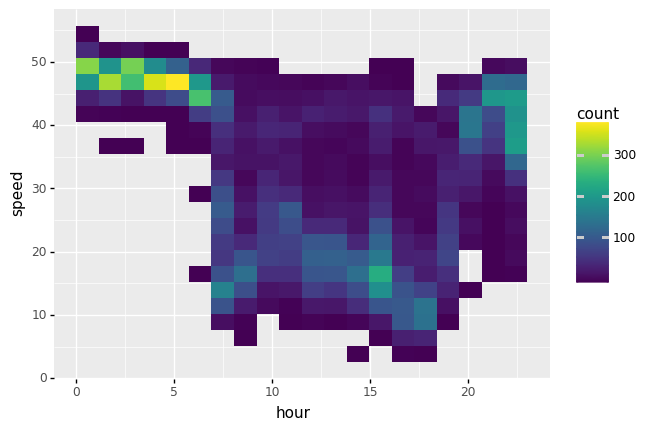

<ggplot: (308708461)>

In [558]:
#ggplot for overview
ggplot(train, aes(x='hour', y='speed')) + geom_bin2d(bins = 20)

In [559]:
#import necessary package
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,make_scorer
from math import sqrt

In [565]:
#choose the useful features for training 
X_train = train[['day', 'month', 'year', 'hour', 'weekdays','dayofyear','timePeriod', 'isholiday','week']]
Y_train = train.speed

In [566]:
#split the train set 
X_train,X_test,Y_train,Y_test=train_test_split(X_train, Y_train, test_size=0.2, random_state = 1)
print(X_train)
print(Y_train)

       day  month  year  hour  weekdays  dayofyear  timePeriod  isholiday  \
12779   10      2  2018    20         6         41           6          0   
3315    19      5  2017    12         5        139           2          0   
1173    19      2  2017     6         7         50           1          0   
11482    7      5  2018     5         1        127           1          0   
10350   19      4  2018    22         4        109           6          0   
...    ...    ...   ...   ...       ...        ...         ...        ...   
905      2      8  2017     2         3        214           1          0   
5192     8      5  2017    18         1        128           5          0   
12172   20      8  2018    11         1        232           2          0   
235      1     10  2017    19         7        274           5          0   
13349   13     11  2018     3         2        317           1          0   

       week  
12779     6  
3315     20  
1173      7  
11482    19  
10350

In [570]:
#grid search for best parameters
'''
from sklearn.model_selection import GridSearchCV
XGBoost = xgb.XGBRegressor()
params = {'learning_rate': [0.05,0.1],
            # 'colsample_bytree': [0.7,0.8,1],
            #'subsample': [0.8,0.9], 
            #'max_depth': [8,10,30],
             #'reg_lambda':[1,2,3],
            #  'min_child_weight': [2,4],
          # 'base_score': [1,3],
          # 'gamma':[0.2,0.6,1]
            }

gridxgb= GridSearchCV(XGBoost, params, scoring='r2', cv=5, verbose=1, n_jobs=5)
gridxgb.fit(X_train, Y_train)
result = gridxgb.cv_results_
print(result)
'''

"\nfrom sklearn.model_selection import GridSearchCV\nXGBoost = xgb.XGBRegressor()\nparams = {'learning_rate': [0.05,0.1],\n            # 'colsample_bytree': [0.7,0.8,1],\n            #'subsample': [0.8,0.9], \n            #'max_depth': [8,10,30],\n             #'reg_lambda':[1,2,3],\n            #  'min_child_weight': [2,4],\n          # 'base_score': [1,3],\n          # 'gamma':[0.2,0.6,1]\n            }\n\ngridxgb= GridSearchCV(XGBoost, params, scoring='r2', cv=5, verbose=1, n_jobs=5)\ngridxgb.fit(X_train, Y_train)\nresult = gridxgb.cv_results_\nprint(result)\n"

In [571]:
#use XGBoost Regressor as the model to predict
import xgboost as xgb
XGBoost = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.8, 
                 n_estimators = 600, reg_lambda = 1,  gamma = 0.6,     
                learning_rate=0.1, scale_pos_weight=3, base_score = 1,
                 max_depth=35,   min_child_weight = 2,                                         
                 alpha = 20)
XGBoost.fit(X_train, Y_train)
predxgbTrain = XGBoost.predict(X_train)
print(r2_score(Y_train, predxgbTrain))
predxgbTest = XGBoost.predict(X_test)
print(r2_score(Y_test, predxgbTest))


0.9736856457881342
0.928847663784779


In [572]:
#get the rmse value
rfmsexgb =mean_squared_error(predxgbTest, Y_test)
print(rfmsexgb)

13.294721672842746


In [573]:
pd.DataFrame(XGBoost.feature_importances_,
             index=X_test.columns,columns=['Importance']).sort_values(by='Importance',ascending=False)[:20]

,Importance
timePeriod,0.778111
hour,0.116152
weekdays,0.035921
isholiday,0.026568
day,0.015486
year,0.007371
week,0.007200
month,0.006942
dayofyear,0.006250


In [574]:
prediction_test = XGBoost.predict(test.drop(['isweekend','quarter'], axis = 1))

In [575]:
prediction = pd.DataFrame({'speed':list(prediction_test)},columns=['speed'])
submission=pd.concat([prediction.speed], axis = 1)
submission.head()

,speed
0,47.235332
1,47.880440
2,37.082718
3,27.299904
4,36.325165


In [539]:
sub = pd.read_csv('data/sampleSubmission.csv')
sub['speed'] = submission
print(sub)

        id      speed
0        0  47.235332
1        1  47.880440
2        2  37.082718
3        3  27.299904
4        4  36.325165
...    ...        ...
3499  3499  13.268041
3500  3500  26.449221
3501  3501  44.536217
3502  3502  40.456333
3503  3503  42.567787

[3504 rows x 2 columns]


In [540]:
sub.to_csv('Prediction.csv',index = False)